# Collab Write Analysis dataset

In [1]:
import pandas as pd
import itertools
from wordcloud import WordCloud

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

nltk.download('punkt')

fill_with_r1 = False
nan_if_multilabels = True

KeyboardInterrupt: 

## Data Exploration and cleaning

In [ ]:
# read the data (format xlsm)
data = pd.read_excel('data/CollabWriteAnalysisCountCodesLadyorTigerF20nS21S22wGSAnalysis27Jan2023_14Mar2024CleanF.xlsm', sheet_name='Combined Discussions')

In [ ]:
# retrieve the columns
data.columns

Index(['Course', 'Book ID', 'Topic', 'Bookclub', 'Chat0CREW1', 'Pseudonym',
       'Message', 'Message Time', 'Is Answer', 'Page', 'Response Number',
       'R1 Discussion type', 'R2DiscussionType',
       'R2DiscussionTypeInterpNothers', 'CollapsR2DiscussionTypeInterpNothers',
       'Chat0CREW1B', 'R1 Dialogic spell', 'BinaryR1DialogicSpell',
       'R1 Uptake', 'BinaryR1Uptake', 'R2DialogicSpell',
       'BinaryR2DialogicSpell', 'R2Uptake', 'BinaryR2Uptake', 'Pseudonym.1',
       'Message.1', 'Bookclub.1', 'R1 Question', 'R2 Question', 'R1 Pivot',
       'R2 Pivot', 'Memo', 'Old Code Book'],
      dtype='object')

Value count:

In [ ]:
for column in data.columns:
    if column in ['Message', 'Pseudonym', 'Message Time']:
        continue
    # value counts
    print(data[column].value_counts())
    
    # print the number of items not nan
    print(data[column].count())
    print()

PIM P1                    452
? S22 Chat Synch Data      98
Outreach P1                53
? S22 Chat Asynch Data      8
Name: Course, dtype: int64
611

260    421
261    190
Name: Book ID, dtype: int64
611

Part 1: What happens next? What is behind the door, the lady or the tiger?  Part 2: Later, the King discovers that his daughter has broken the law.  How does the King respond? What happens?                                                                                                                                                                                                               519
Part 1: Discuss what would happens next and why, providing evidence or logic. What is behind the door, the lady of the tiger?  Part 2: Later, the King discovers that his daughter had broken the law, by first finding out what was behind the doors & then signaling to her lover which door to open. What would the king do, and why? Do NOT write fiction, but rather speculate and provide support. 

## Cleaning

In [ ]:
columns_to_delete = []

# Find the columns which content is equal to each other (and erase them)
for column, column2 in itertools.combinations(data.columns, 2):
    if data[column].equals(data[column2]):
        print(f'{column} is equal to {column2}')
        columns_to_delete.append(column2)

# Delete the columns
data.drop(columns=columns_to_delete, inplace=True)

Bookclub is equal to Bookclub.1
Chat0CREW1 is equal to Chat0CREW1B
Pseudonym is equal to Pseudonym.1
Message is equal to Message.1
BinaryR1DialogicSpell is equal to BinaryR1Uptake
BinaryR1DialogicSpell is equal to BinaryR2Uptake
BinaryR1Uptake is equal to BinaryR2Uptake


In [ ]:
# Memo, old code book, topic are not needed
data.drop(columns=['Memo', 'Old Code Book', 'Topic'], inplace=True)

In [ ]:
# remove the first ? if present
data['Course'] = data['Course'].apply(lambda x: x[2:] if x[0] == '?' else x)

In [ ]:
# if Is Answer is nan or ' ' then it is True, otherwise False
data['Is Answer'] = data['Is Answer'].isna() | data['Is Answer'].str.isspace()

In [ ]:
str_to_int = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
# change bookclub to the number of book club (format Book Club n)
data['Bookclub'] = data['Bookclub'].map(lambda x: str_to_int[x.split(' ')[-1]])

In [ ]:
# Page number is NaN if ' ' or nan or ? 
data['Page'] = data['Page'].map(lambda x: pd.NA if str(x) in ['?'] or pd.isna(x) or str(x).isspace() else x)

In [ ]:
# response number is 0 if ' '
data['Response Number'] = data['Response Number'].map(lambda x: pd.NA if str(x).isspace() or pd.isna(x) else x)

Rename classes:

In [ ]:
# rename Book ID and Chat0CREW1 to book_id and chat_crew
columns_to_rename = {'Book ID': 'book_id', 
                     'Chat0CREW1': 'chat_crew',
                     'Bookclub': 'bookclub',
                     'Course': 'course',
                     'Pseudonym': 'pseudonym',
                     'Message': 'message',
                     'Message Time': 'time',
                     'Is Answer': 'is_answer', 
                     'Page': 'page', 
                     'Response Number': 'response_number', 
                     'R1 Discussion type': 'r1_discussion_type',
                     'R2DiscussionType': 'r2_discussion_type',
                     'R2DiscussionTypeInterpNothers': 'r2_discussion_type_interp_nothers',
                     'CollapsR2DiscussionTypeInterpNothers': 'collaps_r2_discussion_type_interp_nothers',
                     'R1 Dialogic spell': 'r1_dialogic_spell',
                     'BinaryR1DialogicSpell': 'binary_r1_dialogic_spell',
                     'R1 Uptake': 'r1_uptake',
                     'BinaryR1Uptake': 'binary_r1_uptake',
                     'R2DialogicSpell': 'r2_dialogic_spell',
                     'BinaryR2DialogicSpell': 'binary_r2_dialogic_spell',
                     'R2Uptake': 'r2_uptake',
                     'BinaryR2Uptake': 'binary_r2_uptake',
                     'R1 Question': 'r1_question',
                     'R2 Question': 'r2_question',
                     'R1 Pivot': 'r1_pivot',
                     'R2 Pivot': 'r2_pivot'
                     }
data.rename(columns=columns_to_rename, inplace=True)

In [ ]:
if fill_with_r1:
    # copy R1 to R2 if R2 is nan
    for column in data.columns:
        if column.startswith('r2'):
            corr_r1_column = column.replace('r2', 'r1')
            if corr_r1_column in data.columns:
                data[column] = data[column].fillna(data[corr_r1_column])

                # if r2 contains a question mark, then take the value from r1
                for i, row in data.iterrows():
                    if '?' in str(row[column]):
                        data.at[i, column] = row[corr_r1_column]

Drop R1 and binary classes

In [ ]:
# remove r1 columns and binary columns
data = data[[column for column in data.columns if not column.startswith('r1')]]
data = data[[column for column in data.columns if not column.startswith('binary')]]

Check the values of all the classes:

In [ ]:
for column in data.columns:
    if column in ['message', 'pseudonym', 'time']:
        continue
    # value counts
    print(data[column].value_counts(dropna=False))
    
    # print the number of items not nan
    print(data[column].count())
    print()

PIM P1                  452
S22 Chat Synch Data      98
Outreach P1              53
S22 Chat Asynch Data      8
Name: course, dtype: int64
611

260    421
261    190
Name: book_id, dtype: int64
611

1    277
4    192
2     94
3     30
5     18
Name: bookclub, dtype: int64
611

1    421
0    190
Name: chat_crew, dtype: int64
611

False    503
True     108
Name: is_answer, dtype: int64
611

10      334
<NA>    102
9        96
13       46
8        32
3         1
Name: page, dtype: int64
509

<NA>    191
3.4      97
2.4      94
3.2      63
2.1      60
2.2      24
3.5      18
1.1      18
1.3      12
2.3      12
3.1       9
1.2       7
3.3       6
Name: response_number, dtype: int64
420

Seminar                  333
Deliberation              85
Social                    69
UX                        47
Procedure                 46
Imaginative entry         17
Other                      6
Seminar, Deliberation      2
Imaginative                2
Social, Deliberation       1
Deliberation, Semin

Creating a mapping from discussion type to collaps discussion type interp nothers:

In [ ]:
discussion_to_collaps = {}
for index, row in data.iterrows():
    if row['r2_discussion_type'] not in discussion_to_collaps:
        discussion_to_collaps[row['r2_discussion_type']] = row['collaps_r2_discussion_type_interp_nothers']
    else:
        # check if the value is the same
        if discussion_to_collaps[row['r2_discussion_type']] != row['collaps_r2_discussion_type_interp_nothers']:
            print(f'Error in {row["r2_discussion_type"]}, {discussion_to_collaps[row["r2_discussion_type"]]} != {row["collaps_r2_discussion_type_interp_nothers"]}')

These are probable errors in the collaps. I will mantain the mapping.

In [ ]:
data.drop(columns=['collaps_r2_discussion_type_interp_nothers', 'r2_discussion_type_interp_nothers'], inplace=True)
discussion_to_collaps

{'Social': 'Social/Procedural/UX',
 'Seminar': 'Interpretation',
 'Procedure': 'Social/Procedural/UX',
 'Other': 'Other',
 'Deliberation': 'Deliberation',
 'UX': 'Social/Procedural/UX',
 'Imaginative entry': 'Other',
 'Seminar, Deliberation': 'Interpretation',
 'Social, Deliberation': 'Social/Procedural/UX',
 'Deliberation, Seminar': 'Deliberation',
 'Social, Procedure': 'Social/Procedural/UX',
 'Imaginative': 'Other',
 'Imaginative Entry': 'Deliberation'}

### Class cleaning

Split the messages or duplicate them if they contain more classes (best split is based on '\n', '.', '?', '!', ';', ',', ' '; it is not possible to split only by successive split_char, so the order matter).

In [ ]:
def check_class(data_to_check, column, divide_also =[], take_last_of = [], change_to = pd.NA):
    new_data = data_to_check.copy()

    rows_added = 0
    rows_without_splitting = 0
    
    # I want to see if the r2_discussion_type is a list of discussion types
    rows_to_check = new_data[new_data[column].notna() & new_data[column].str.contains(',')].iterrows()

    for index, row in rows_to_check:
        types = row[column].split(',')
        n_types = len(types)

        # get sentences
        message = sent_tokenize(row['message'])
        
        # if both the parts are not empty and the number of parts is equal to the number of types
        if len(message) == n_types and all(message_part for message_part in message):
            # I have found the right split, add rows to the data and remove the old row
            data_to_insert = pd.DataFrame(columns=new_data.columns)
            data_index = index + rows_added
            for type_index, (type_, message_part) in enumerate(zip(types, message)):
                data_to_insert.loc[len(data_to_insert.index)] = row
                data_to_insert.loc[data_to_insert.index[-1], column] = type_.strip()
                data_to_insert.loc[data_to_insert.index[-1], 'message'] = message_part
                if type_index < n_types - 1:
                    for column_to_remove in take_last_of:
                        data_to_insert.loc[data_to_insert.index[-1], column_to_remove] = pd.NA
                for column_to_check in divide_also:
                    other_column = new_data.loc[data_index, column_to_check]
                    if other_column and not pd.isna(other_column):
                        other_column = str(other_column).split(',')
                        if len(other_column) == n_types:
                            data_to_insert.loc[data_to_insert.index[-1], column_to_check] = other_column[type_index].strip()
                rows_added += 1
            
            new_data = pd.concat([new_data.loc[:data_index - 1], data_to_insert, new_data.loc[data_index + 1:]]).reset_index(drop=True)
            rows_added -= 1
        else:
            # check if all the types are the same
            if len(set(types)) != 1:
                if nan_if_multilabels:
                    new_data.loc[index + rows_added, column] = change_to
                else:
                    rows_without_splitting += 1

                    # if I did not find the right split, duplicate the row and remove the multiple types
                    data_to_insert = pd.DataFrame(columns=new_data.columns)
                    data_index = index + rows_added
                    for type_index, type_ in enumerate(types):
                        data_to_insert.loc[len(data_to_insert.index)] = row
                        data_to_insert.loc[data_to_insert.index[-1], column] = type_.strip()

                        if type_index < n_types - 1:
                            for column_to_remove in take_last_of:
                                data_to_insert.loc[data_to_insert.index[-1], column_to_remove] = pd.NA

                        for column_to_check in divide_also:
                            other_column = new_data.loc[data_index, column_to_check]
                            if other_column and not pd.isna(other_column):
                                other_column = str(other_column).split(',')
                                if len(other_column) == n_types:
                                    data_to_insert.loc[data_to_insert.index[-1], column_to_check] = other_column[type_index].strip()

                        rows_added += 1

                    new_data = pd.concat([new_data.loc[:data_index - 1], data_to_insert, new_data.loc[data_index + 1:]]).reset_index(drop=True)
                    rows_added -= 1
            else:
                # remove the multiple types
                new_data.loc[index, column] = types[0].strip()
                
    return new_data

Discussion Type

In [ ]:
data = check_class(data, 'r2_discussion_type', divide_also=['r2_question'], take_last_of=['r2_pivot'], change_to = 'Other')

wrong_types = {'Imaginative entry' : 'Imaginative Entry',
               'Imaginative': 'Imaginative Entry'}

data['r2_discussion_type'] = data['r2_discussion_type'].replace(wrong_types)

# strip the values
data['r2_discussion_type'] = data['r2_discussion_type'].str.strip()

print(data['r2_discussion_type'].value_counts(dropna=False))

Seminar              335
Deliberation          87
Social                70
Procedure             47
UX                    47
Imaginative Entry     20
Other                  8
Name: r2_discussion_type, dtype: int64


/tmp/ipykernel_23951/364900255.py:37: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  new_data = pd.concat([new_data.loc[:data_index - 1], data_to_insert, new_data.loc[data_index + 1:]]).reset_index(drop=True)


Dialogic spell

In [ ]:
# Page number is NaN if ' ' or nan or ? 
data['r2_dialogic_spell'] = data['r2_dialogic_spell'].map(lambda x: pd.NA if str(x) in ['?', '\xa0'] or pd.isna(x) or str(x).isspace() else x)

# change Begin to 1 if not NA
#data['r2_dialogic_spell'] = data['r2_dialogic_spell'].map(lambda x: 1 if pd.notna(x) and x == 'Begin' else x)

#for i, row in data.iterrows():
#    if pd.notna(row['r2_dialogic_spell']) and row['r2_dialogic_spell'] in ['End', 'Break']:
#        data.at[i, 'r2_dialogic_spell'] = data.at[i - 1, 'r2_dialogic_spell']

# change everything to integers
data['r2_dialogic_spell'] = data['r2_dialogic_spell'].map(lambda x: int(x) if pd.notna(x) else x)

print(data['r2_dialogic_spell'].value_counts(dropna=False))

1       200
<NA>    150
2       126
3        65
4        29
7        21
5        13
6        10
Name: r2_dialogic_spell, dtype: int64


Uptake:

In [ ]:
data['r2_uptake'] = data['r2_uptake'].map(lambda x: pd.NA if str(x) in ['?', '\xa0'] or pd.isna(x) or str(x).isspace() else x)

print(data['r2_uptake'].value_counts(dropna=False))

<NA>         243
Affirm       142
Elaborate    108
Filler        61
Clarify       50
Disagree      10
Name: r2_uptake, dtype: int64


Questions

In [ ]:
data = check_class(data, 'r2_question', take_last_of=['r2_pivot'])

right_types = ['C-HOT', 'O-HOT', 'C-LOT', 'O-LOT']

# pd.NA if ' ' or nan or ?
data['r2_question'] = data['r2_question'].map(lambda x: pd.NA if pd.isna(x) or str(x) in ['?', '\xa0'] or str(x).isspace() or '?' in str(x) or str(x) not in right_types else x)

print(data['r2_question'].value_counts(dropna=False))

<NA>     533
C-LOT     42
C-HOT     22
O-HOT     12
O-LOT      8
Name: r2_question, dtype: int64


Pivot

In [ ]:
# create from pivot column
data['r2_pivot'] = data['r2_pivot'].map(lambda x: pd.NA if str(x) in ['?', '\xa0'] or pd.isna(x) or str(x).isspace() else x)

# Make not possible to have a pivot with more to
data['r2_pivot'] = data['r2_pivot'].map(lambda x: pd.NA if pd.isna(x) or len(x.split(' to ')) > 2 else x)

data['from_pivot'] = data['r2_pivot'].map(lambda x: pd.NA if pd.isna(x) else x.split(' to ')[0].strip())
data['to_pivot'] = data['r2_pivot'].map(lambda x: pd.NA if pd.isna(x) else x.split(' to ')[1].strip())

misspellings = {
    'Imaginative' : 'Imaginative Entry',
    'Imaginative entry' : 'Imaginative Entry',
    'Delibration' : 'Deliberation',
    'Deliberationa' : 'Deliberation',
    'Deliberation/Social/Procedure/UX' : 'Social/Procedure/UX',
    'Socal' : 'Social/Procedure/UX',
}

data['from_pivot'] = data['from_pivot'].replace(misspellings)
data['to_pivot'] = data['to_pivot'].replace(misspellings)
data.drop(columns=['r2_pivot'], inplace=True)

print(data['from_pivot'].value_counts(dropna=False))
print()
print(data['to_pivot'].value_counts(dropna=False))

<NA>                   570
Seminar                 20
Social/Procedure/UX     15
Deliberation             9
Imaginative Entry        3
Name: from_pivot, dtype: int64

<NA>                   570
Social/Procedure/UX     18
Seminar                 16
Deliberation            10
Imaginative Entry        3
Name: to_pivot, dtype: int64


In [ ]:
misplaced = 0
corrected = 0

small_collaps = {
    'Imaginative Entry': 'Imaginative Entry',
    'Deliberation': 'Deliberation',
    'Social' : 'Social/Procedure/UX',
    'Procedure' : 'Social/Procedure/UX',
    'UX' : 'Social/Procedure/UX',
    'Seminar' : 'Seminar',
    'Other': 'Other'
}

for index, row in data.iterrows():
    if pd.notna(row['from_pivot']) and pd.notna(row['to_pivot']):
        current_type = row['r2_discussion_type']

        previous_row = data.loc[index - 1]
        previous_type = previous_row['r2_discussion_type']

        if previous_type not in small_collaps or current_type not in small_collaps:
            continue

        if row['from_pivot'] == small_collaps[previous_row['r2_discussion_type']] and row['to_pivot'] == small_collaps[row['r2_discussion_type']]:
            corrected += 1
        else:
            from_pivot = row['from_pivot']
            to_pivot = row['to_pivot']
            print(f'Misplaced {from_pivot} to {to_pivot}')

            guess_from_pivot = small_collaps[previous_row["r2_discussion_type"]]
            guess_to_pivot = small_collaps[row["r2_discussion_type"]]

            print(f'Guessed {guess_from_pivot} to {guess_to_pivot}')
            print()
            misplaced += 1

print(f'Corrected: {corrected}, Misplaced: {misplaced}')

Misplaced Seminar to Social/Procedure/UX
Guessed Seminar to Seminar

Misplaced Social/Procedure/UX to Seminar
Guessed Seminar to Social/Procedure/UX

Misplaced Social/Procedure/UX to Deliberation
Guessed Deliberation to Deliberation

Misplaced Seminar to Deliberation
Guessed Seminar to Other

Misplaced Seminar to Social/Procedure/UX
Guessed Deliberation to Seminar

Misplaced Deliberation to Seminar
Guessed Social/Procedure/UX to Seminar

Misplaced Seminar to Deliberation
Guessed Deliberation to Deliberation

Corrected: 40, Misplaced: 7


### Save and try history

In [ ]:
data.columns

Index(['course', 'book_id', 'bookclub', 'chat_crew', 'pseudonym', 'message',
       'time', 'is_answer', 'page', 'response_number', 'r2_discussion_type',
       'r2_dialogic_spell', 'r2_uptake', 'r2_question', 'from_pivot',
       'to_pivot'],
      dtype='object')

In [ ]:
columns_to_predict = ['r2_discussion_type', 'r2_dialogic_spell', 'r2_uptake', 'r2_question', 'from_pivot', 'to_pivot']

In [ ]:
# copy only message and r2_discussion_type
discussion_data = data.copy()
columns_to_drop = columns_to_predict.copy()

columns_to_drop.remove('r2_discussion_type')

discussion_data.drop(columns=columns_to_drop, inplace=True)
discussion_data.rename(columns={'r2_discussion_type': 'discussion_type'}, inplace=True)
                       
# save to csv
discussion_data.to_csv('cleaned_data/discussion_data_all.csv', index=False)

In [ ]:
# 

## Plots

### Word cloud

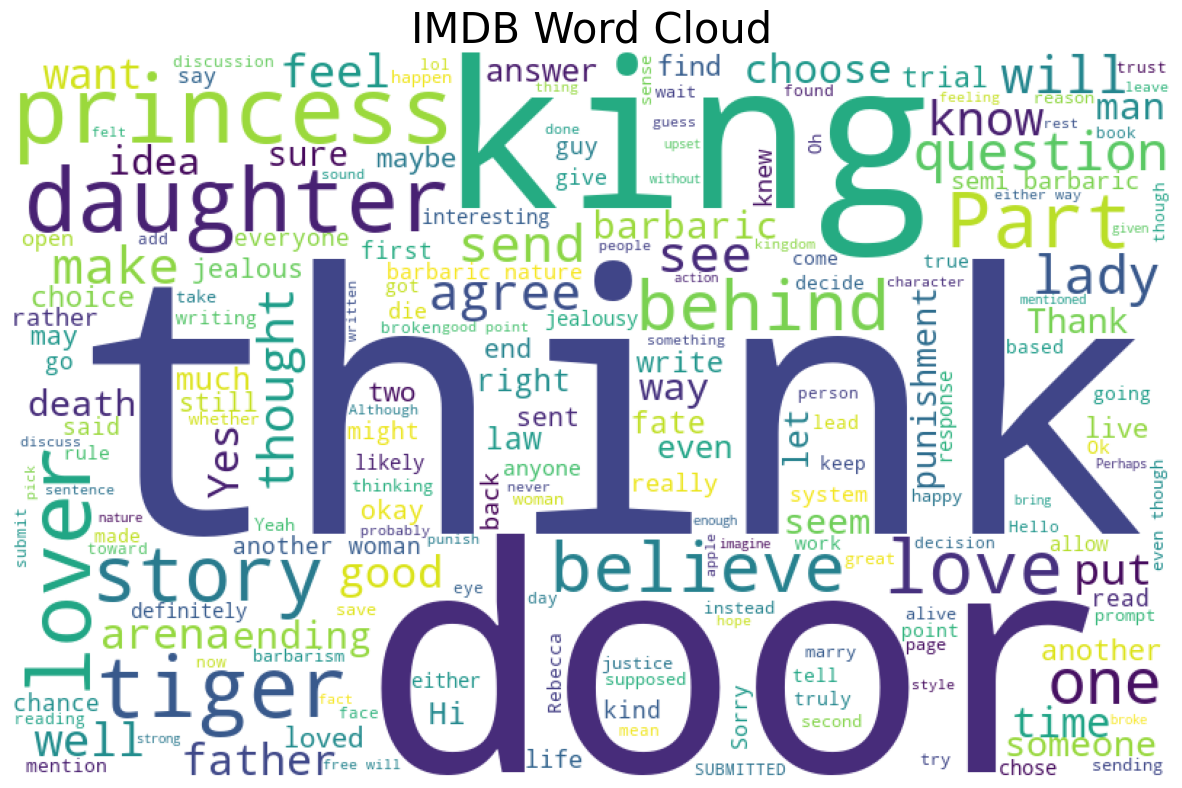

In [70]:
messages = data['message']

plt.figure(figsize=(15, 15))
wc = WordCloud(background_color='white',
               width=800,
               height=500).generate(" ".join(messages))
plt.imshow(wc)
plt.axis('off')
plt.title('IMDB Word Cloud', fontsize=30)
plt.savefig('./images/wordcloud.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [60]:
# Assuming your DataFrame is named df
message_lengths = data['message'].str.len()

# Create a histogram plot using Plotly Express
fig = px.histogram(x=message_lengths, nbins=50, labels={'x': 'Message Length', 'y': 'Frequency'})
fig.update_layout(title='Distribution of Message Lengths')
fig.show()

#Save
fig.write_image('./images/message_length_histogram.pdf', format='pdf')

In [61]:
message_counts = data['pseudonym'].value_counts()[:30]

# Create a bar chart using Plotly Express
fig = px.bar(x=message_counts.index, y=message_counts.values, labels={'x': 'Pseudonym', 'y': 'Number of Messages'})
fig.update_layout(title='Distribution of Messages per Pseudonym')
fig.show()

fig.write_image('./images/messages_per_pseudonym.pdf', format='pdf')

In [62]:
all_tokens = []
for message in data['message']:
    tokens = word_tokenize(message)
    all_tokens.extend(tokens)

# Find the longest and shortest tokens
longest_token = max(all_tokens, key=len)
shortest_token = min(all_tokens, key=len)

print("Longest Token:", longest_token)
print("Shortest Token:", shortest_token)

Longest Token: thoughts/suggestions
Shortest Token: .


In [63]:
time_data = data[['time', 'message']].copy()

# Convert the 'time' column to datetime format
time_data['time'] = pd.to_datetime(time_data['time'], errors='coerce')

time_data = time_data.dropna(subset=['time'])

# messages over date
time_data['date'] = time_data['time'].dt.date
messages_per_date = time_data.groupby('date').size().reset_index(name='count')

# Create a line plot using Plotly Express
fig = px.line(messages_per_date, x='date', y='count', labels={'date': 'Date', 'count': 'Number of Messages'})
fig.update_layout(title='Distribution of Messages Over Time')
fig.show()
fig.write_image('./images/messages_over_time.pdf', format='pdf')

# messages over hour
time_data['hour'] = time_data['time'].dt.hour
messages_per_hour = time_data.groupby('hour').size().reset_index(name='count')

# Create a bar chart using Plotly Express
fig = px.bar(messages_per_hour, x='hour', y='count', labels={'hour': 'Hour', 'count': 'Number of Messages'})
fig.update_layout(title='Distribution of Messages Over Hours')
fig.show()
fig.write_image('./images/messages_over_hour.pdf', format='pdf')

In [64]:
# Count the number of messages per book club
message_counts_by_bookclub = data['bookclub'].value_counts()

# Create a bar chart using Plotly Express
fig = px.bar(x=message_counts_by_bookclub.index, y=message_counts_by_bookclub.values, 
             labels={'x': 'Book Club', 'y': 'Number of Messages'},
             title='Distribution of Messages by Book Club')
fig.show()
fig.write_image('./images/messages_by_bookclub.pdf', format='pdf')

In [65]:
# Count the number of messages per response number
message_counts_by_response_number = data['response_number'].value_counts()

# Create a bar chart using Plotly Express
fig = px.bar(x=message_counts_by_response_number.index.astype(str), y=message_counts_by_response_number.values, 
             labels={'x': 'Response Number', 'y': 'Number of Messages'},
             title='Distribution of Messages by Response Number')
fig.show()

fig.write_image('./images/messages_by_response_number.pdf', format='pdf')

In [66]:
# Define the columns for which you want to create plots
columns_to_plot = ['r2_discussion_type', 'r2_dialogic_spell', 'r2_uptake', 'r2_question', 'from_pivot', 'to_pivot']

# Create plots for each category
for column in columns_to_plot:
    # Replace NaN values with 'None' for categorical columns
    data[column] = data[column].fillna('None')
    
    # Count the number of messages per category
    message_counts_by_category = data[column].value_counts()
    
    # Create a bar chart using Plotly Express
    fig = px.bar(x=message_counts_by_category.index, y=message_counts_by_category.values, 
                 labels={'x': column, 'y': 'Number of Messages'},
                 title=f'Distribution of Messages by {column}')
    fig.show()

    fig.write_image(f'./images/messages_by_{column}.pdf', format='pdf')